# 02 - Cell Type Annotation

This notebook demonstrates clustering and cell type annotation for single-cell data.

## Overview

Steps include:
1. Load preprocessed data
2. Neighbor graph construction
3. Clustering (Leiden algorithm)
4. UMAP visualization
5. Marker gene identification
6. Cell type annotation

## Setup

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(10, 10))

print(f"Scanpy version: {sc.__version__}")

Scanpy version: 1.11.5


C:\Users\dell\AppData\Local\Temp\ipykernel_39816\1463151136.py:12: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


## Load Configuration and Data

In [64]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [51]:
# Load preprocessed data
adata = sc.read_h5ad('../data/processed/preprocessed_data.h5ad')

print(f"Loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

Loaded data: 7839 cells x 23542 genes


AnnData object with n_obs × n_vars = 7839 × 23542
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm'

## Neighborhood Graph

Construct k-nearest neighbor graph in PCA space.

In [ ]:
# Compute neighborhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=config['cell_annotation']['n_neighbors'],
    n_pcs=config['cell_annotation']['n_pcs']
)

print("Neighborhood graph computed")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
Neighborhood graph computed


## Clustering

Apply Leiden clustering algorithm.

In [61]:
# Leiden clustering
sc.tl.leiden(
    adata,
    # resolution=config['cell_annotation']['resolution'],
    resolution=0.8,
    random_state=config['compute']['random_state']
)

print(f"Identified {adata.obs['leiden'].nunique()} clusters")
print(adata.obs['leiden'].value_counts().sort_index())

# for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
#     sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
#     print(f"Resolution {res}: {adata.obs[f'leiden_{res}'].nunique()} clusters")

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Identified 22 clusters
leiden
0     1365
1     1079
2      975
3      752
4      571
5      470
6      414
7      365
8      332
9      229
10     219
11     200
12     194
13     186
14     156
15      92
16      55
17      55
18      46
19      39
20      30
21      15
Name: count, dtype: int64


## UMAP Visualization

Compute UMAP embedding for visualization.

In [62]:
# Compute UMAP
sc.tl.umap(
    adata,
    min_dist=config['visualization']['umap_min_dist'],
    spread=config['visualization']['umap_spread'],
    random_state=config['compute']['random_state']
)

print("UMAP embedding computed")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
UMAP embedding computed


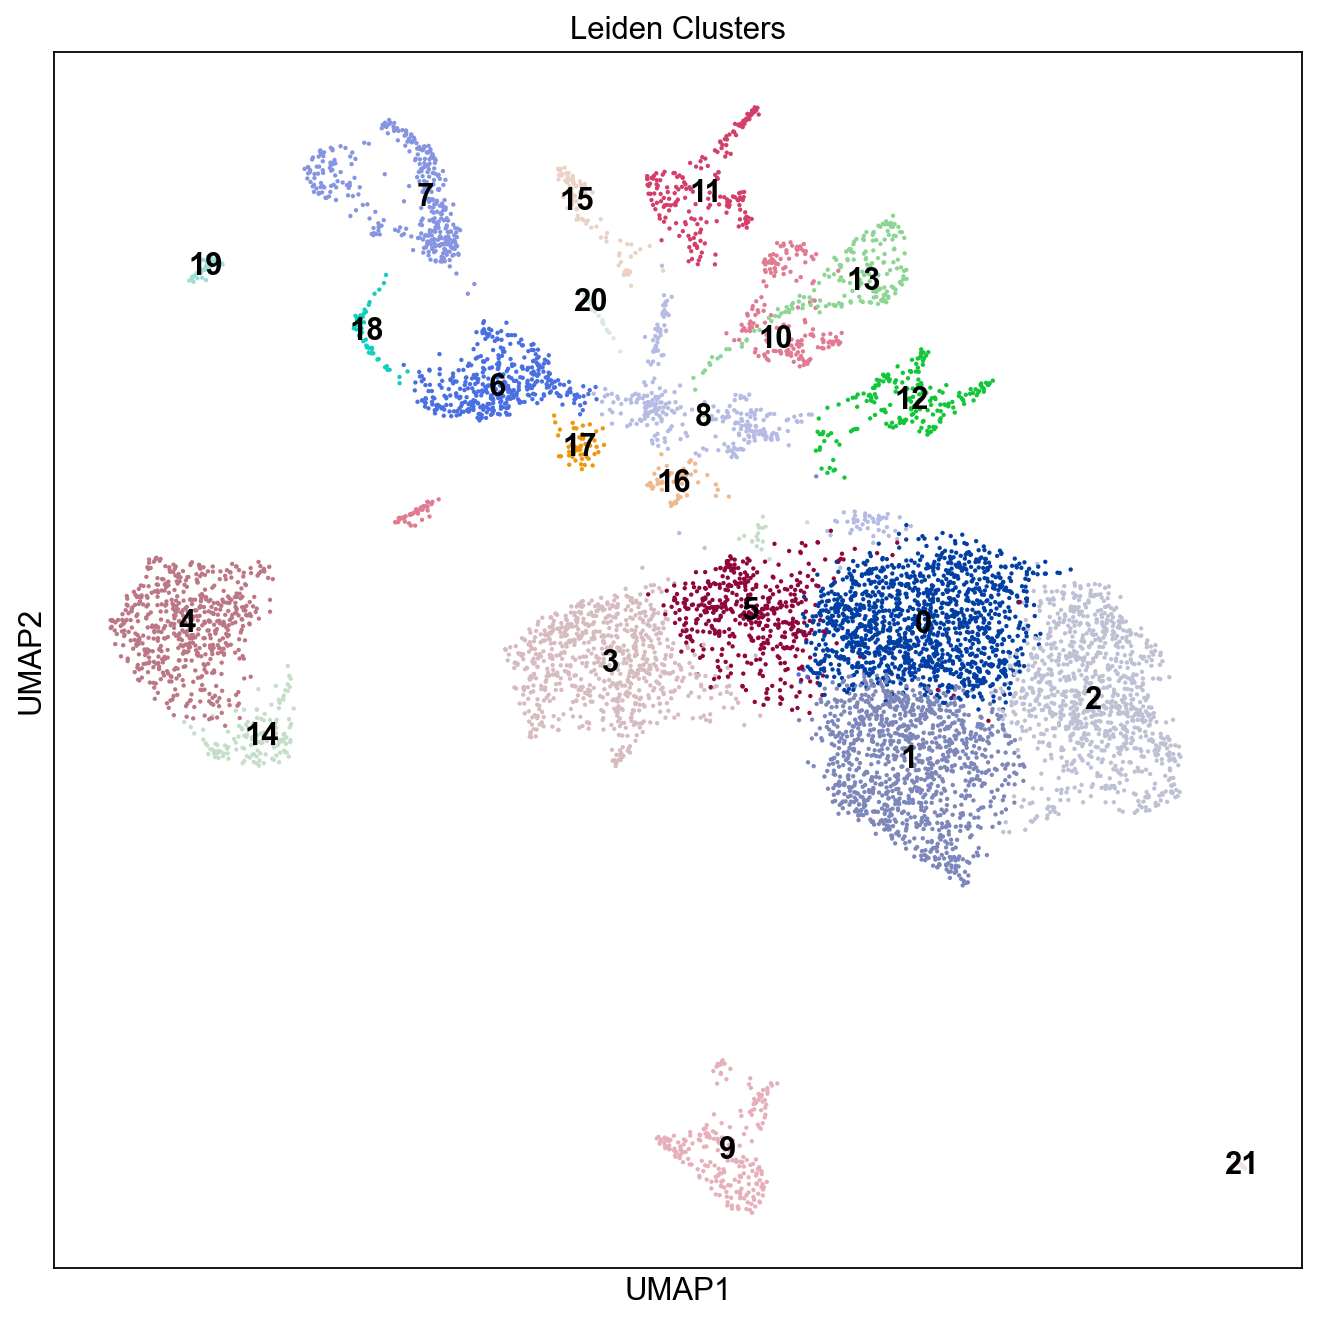

In [63]:
# Visualize clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='Leiden Clusters')

## Marker Gene Identification

Find differentially expressed genes for each cluster.

In [39]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Find marker genes for each cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    key_added='rank_genes'
)

print("Marker gene analysis complete")

ranking genes
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:37)
Marker gene analysis complete


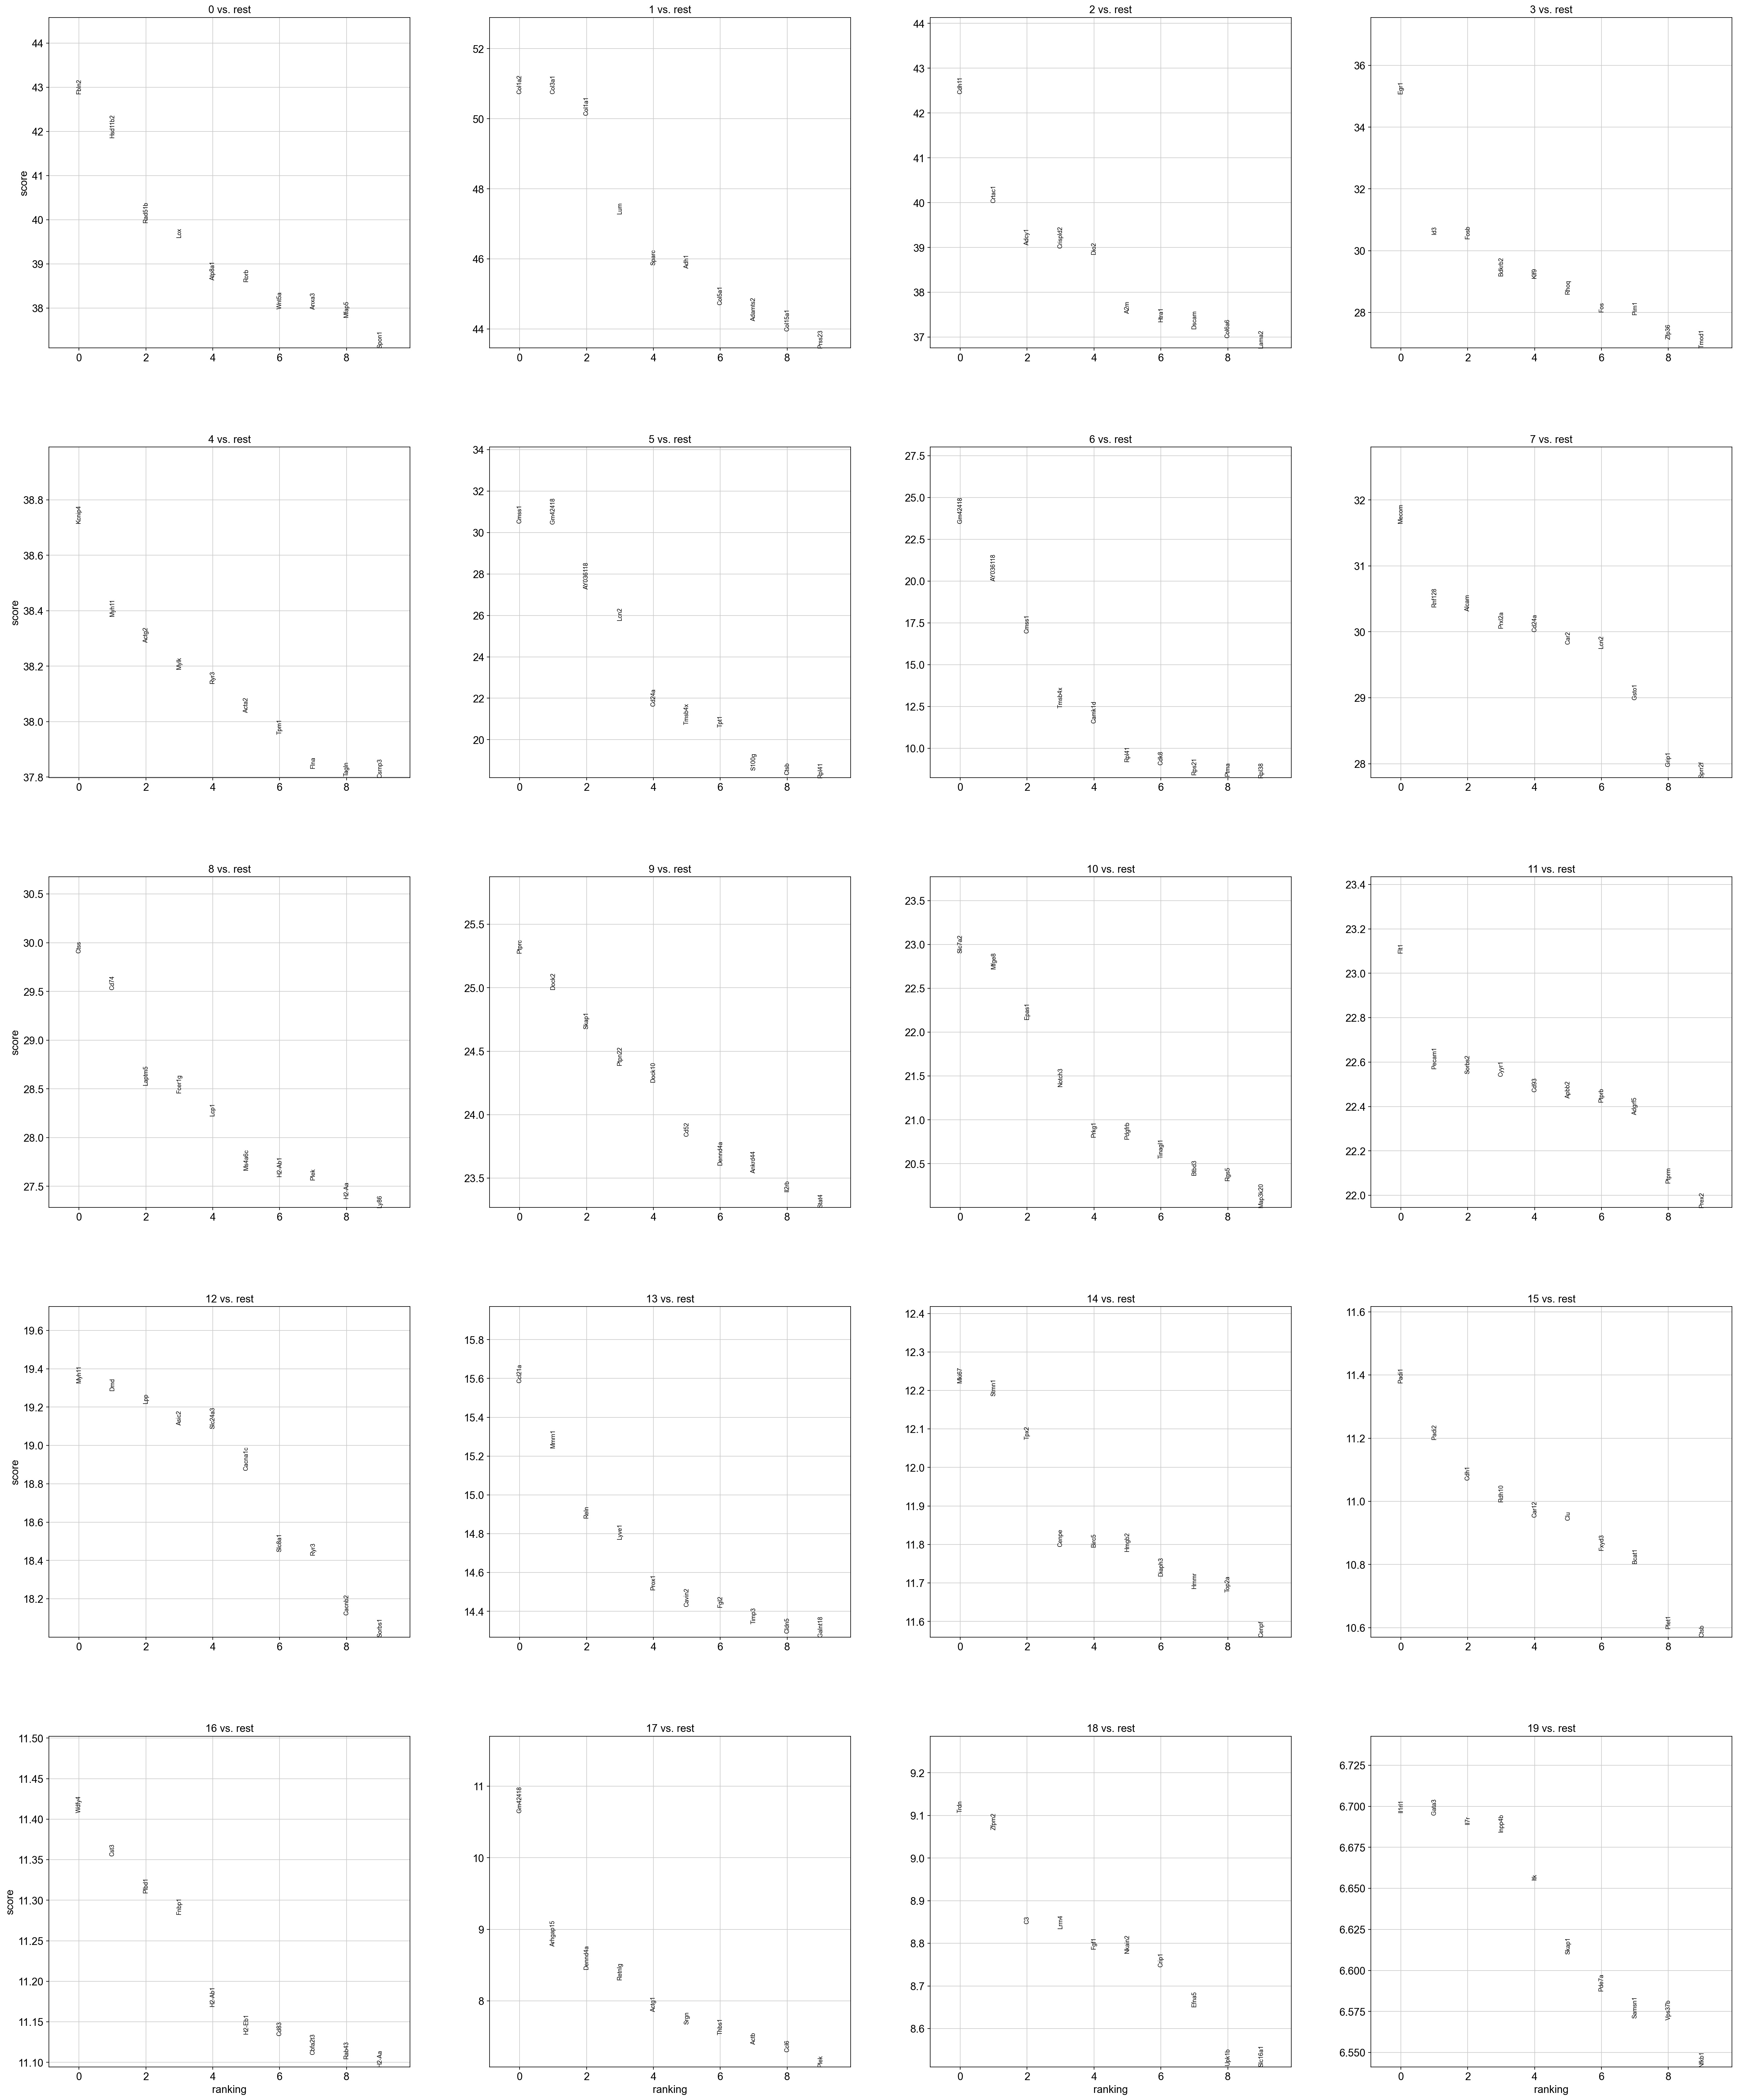

In [40]:
# Visualize top marker genes
sc.pl.rank_genes_groups(adata, n_genes=10, key='rank_genes', sharey=False)

In [41]:
# Get top marker genes as dataframe
marker_df = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes')
# save matrix
marker_df.to_csv('../results/tables/marker_genes.csv', index=False)
marker_df.head(20)

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Fbln2,42.854603,NaN,0.000000e+00,0.000000e+00
1,0,Hsd11b2,41.860325,NaN,0.000000e+00,0.000000e+00
2,0,Rad51b,39.937492,NaN,0.000000e+00,0.000000e+00
3,0,Lox,39.597954,NaN,0.000000e+00,0.000000e+00
4,0,Atp8a1,38.627468,NaN,0.000000e+00,0.000000e+00
5,0,Rorb,38.599178,NaN,0.000000e+00,0.000000e+00
6,0,Wnt5a,37.976955,NaN,0.000000e+00,0.000000e+00
7,0,Anxa3,37.967278,NaN,0.000000e+00,0.000000e+00
8,0,Mfap5,37.787174,NaN,0.000000e+00,0.000000e+00
9,0,Spon1,37.093945,NaN,3.517529e-301,8.280967e-298


## Cell Type Annotation

Annotate clusters based on known marker genes.

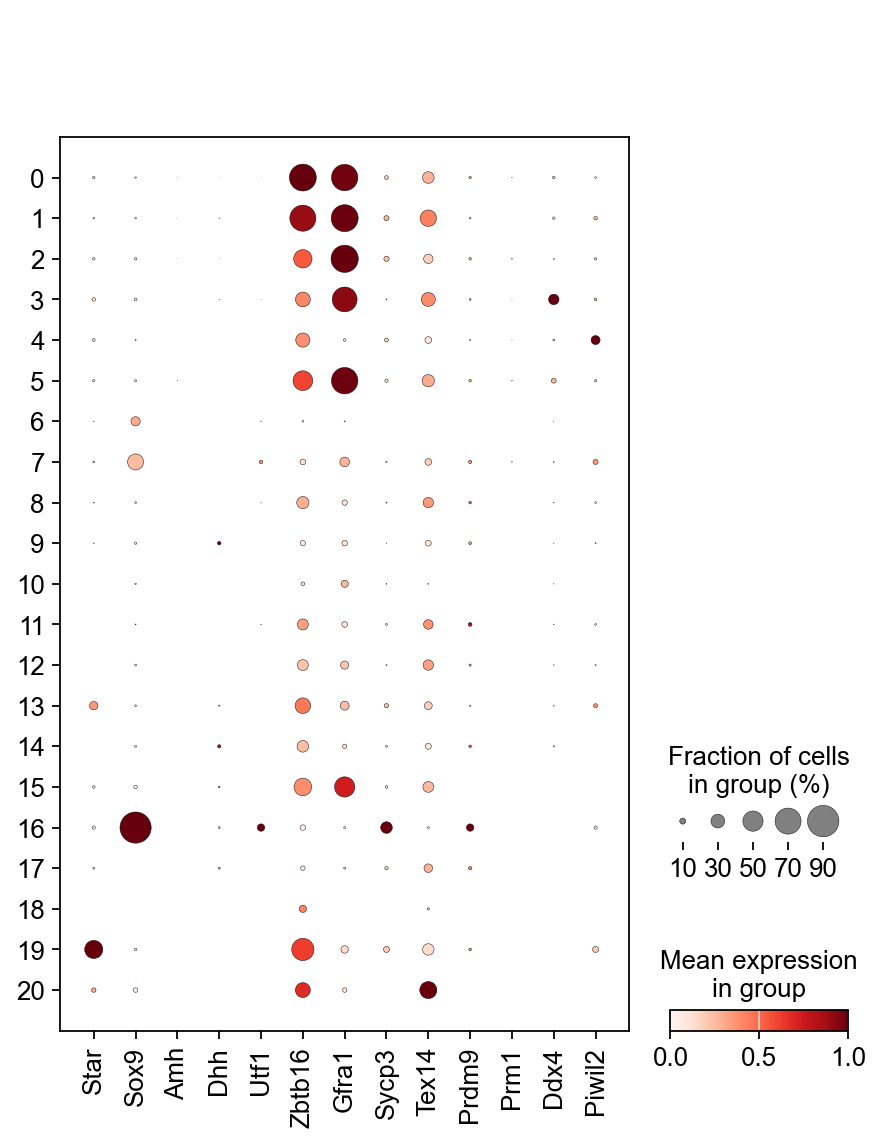

In [12]:
# Define marker genes for reproductive tissue cell types
marker_genes = config['cell_annotation']['marker_genes']

# Visualize marker gene expression
all_markers = [gene for genes in marker_genes.values() for gene in genes]
available_markers = [g for g in all_markers if g in adata.var_names]

if len(available_markers) > 0:
    sc.pl.dotplot(
        adata,
        var_names=available_markers[:15],  # Show first 15 available markers
        groupby='leiden',
        standard_scale='var'
    )
else:
    print("Note: Marker genes not found in dataset.")

In [14]:
# Manual annotation based on marker gene expression
# This is a template - adjust based on your actual data

cluster_annotations = {
    '0': 'Cell Type A',
    '1': 'Cell Type B',
    '2': 'Cell Type C',
    # Add more annotations based on your analysis
}

# Map cluster IDs to cell type names
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

# For unmapped clusters, keep cluster ID
adata.obs['cell_type'] = adata.obs['cell_type'].fillna('Cluster ' + adata.obs['leiden'])

print("Cell type annotations:")
print(adata.obs['cell_type'].value_counts())

TypeError: can only concatenate str (not "Categorical") to str

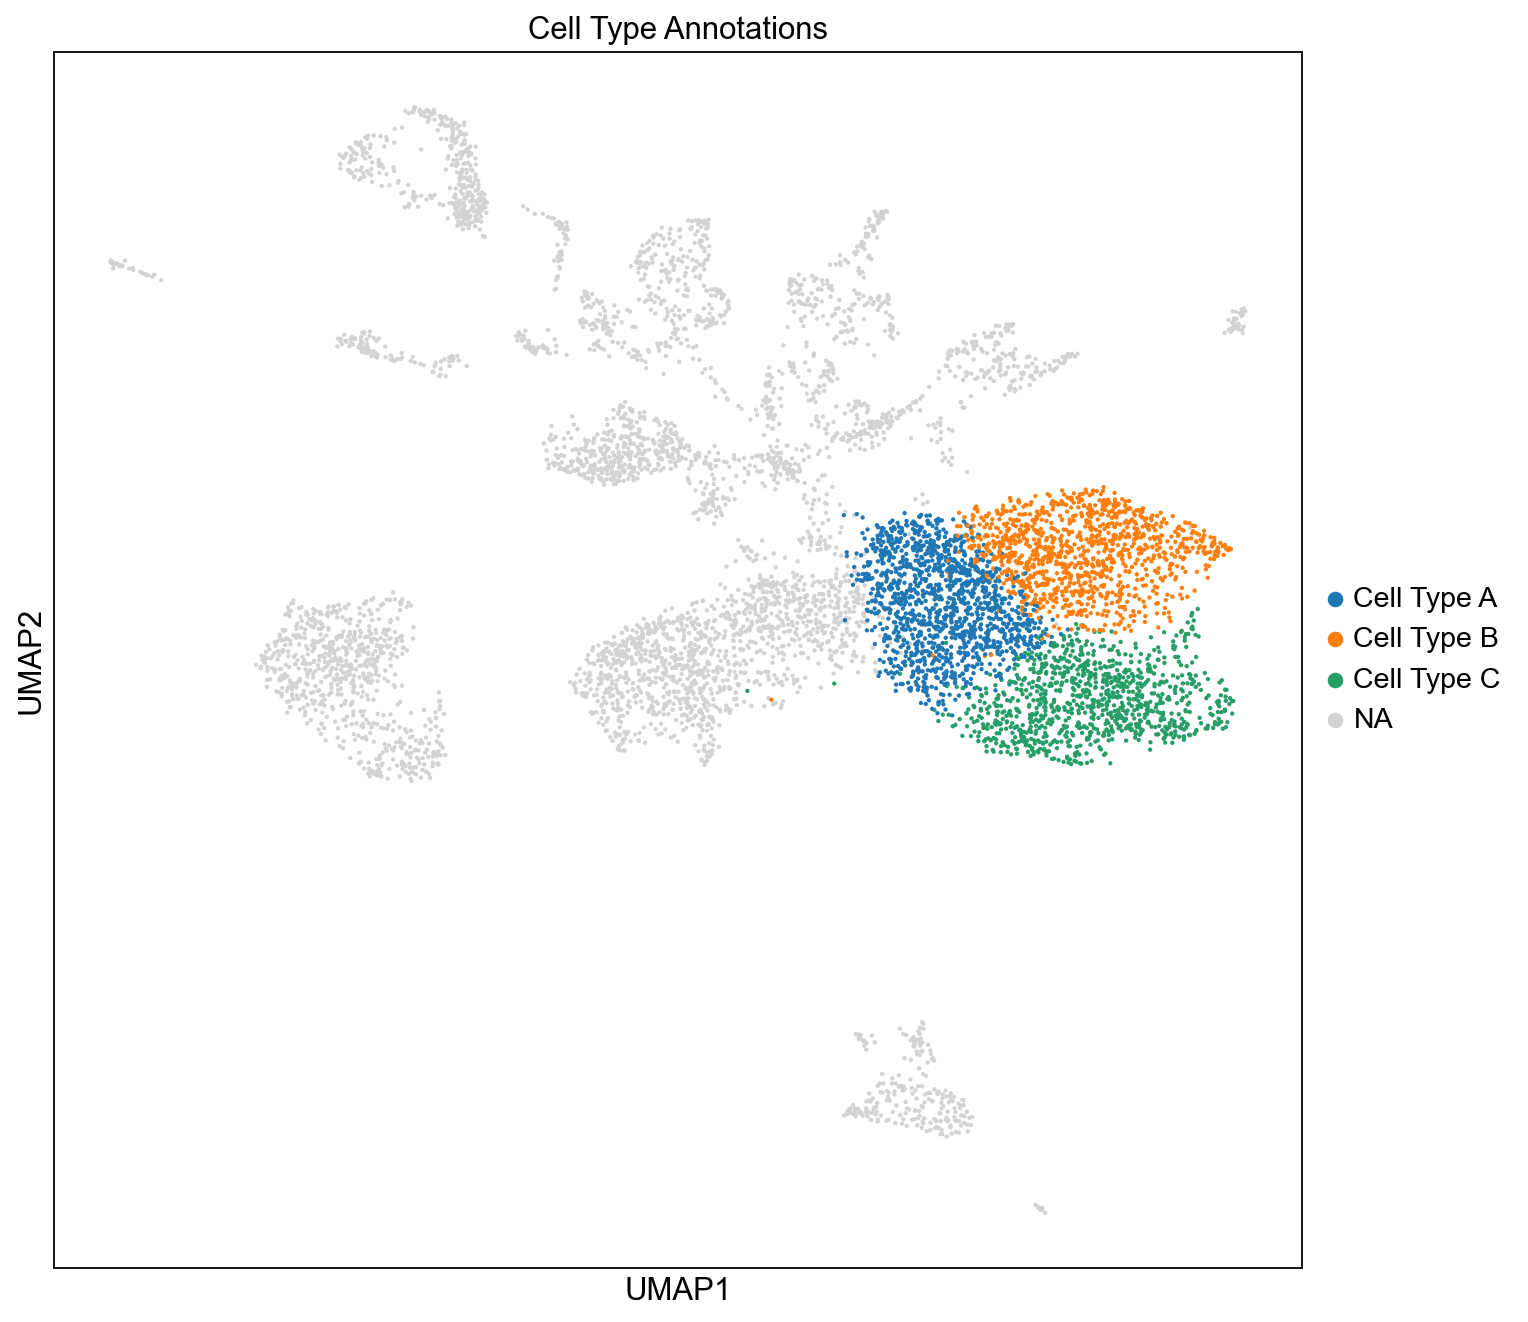

In [15]:
# Visualize cell types
sc.pl.umap(adata, color='cell_type', title='Cell Type Annotations')

## Quality Checks

Verify cell type annotations with QC metrics.

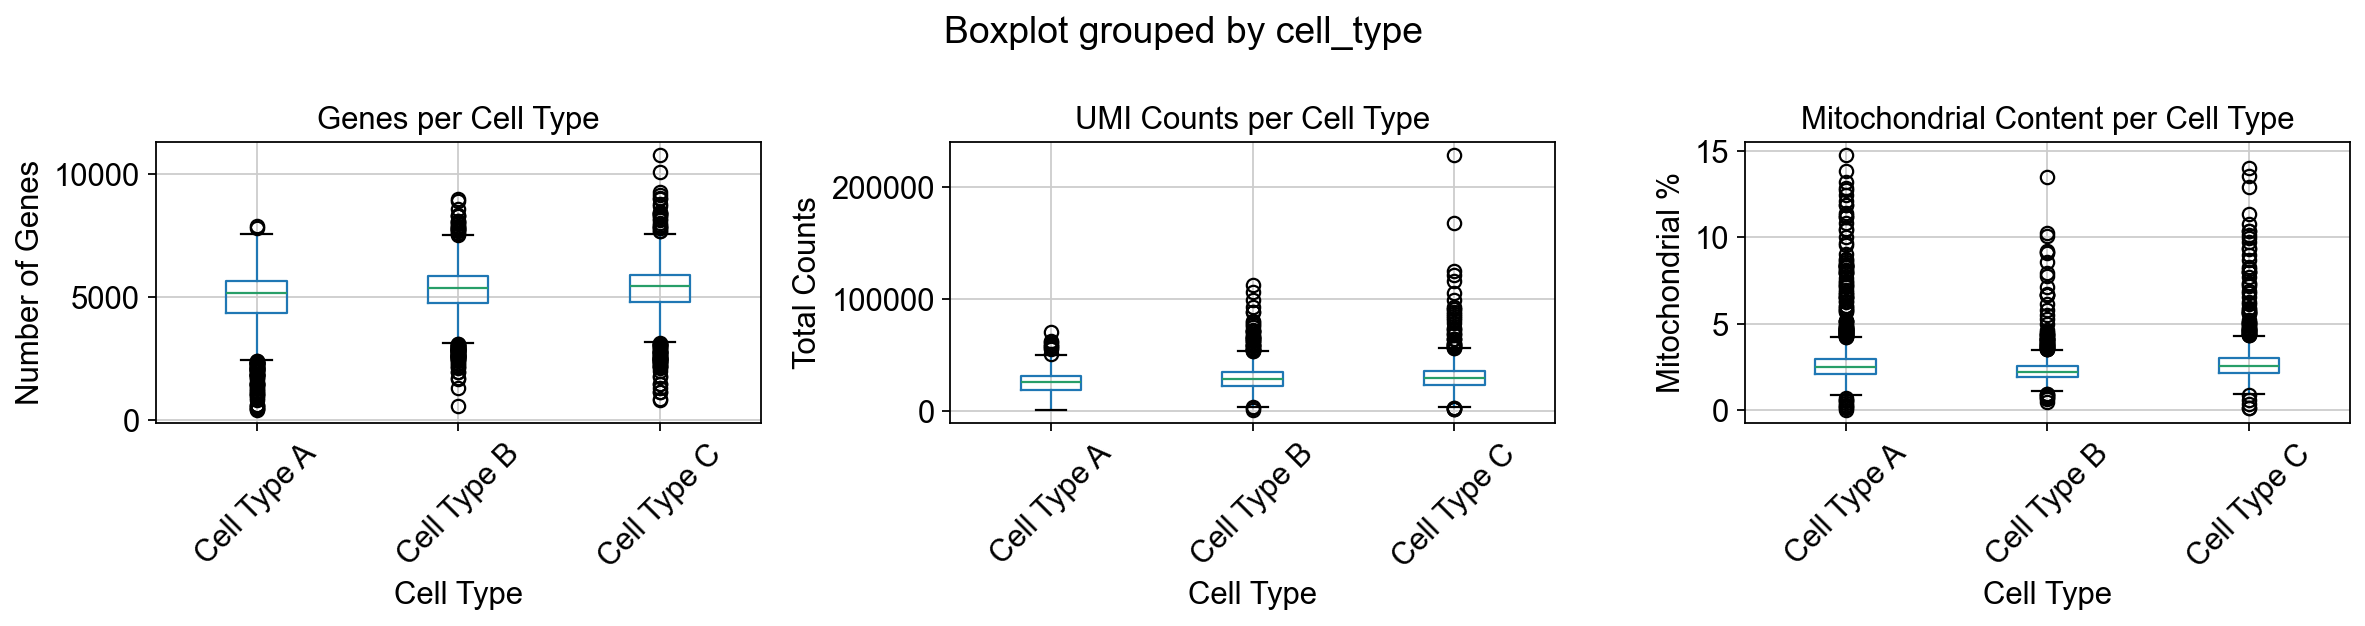

In [16]:
# Compare QC metrics across cell types
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Number of genes
adata.obs.boxplot('n_genes_by_counts', by='cell_type', ax=axes[0])
axes[0].set_xlabel('Cell Type')
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Genes per Cell Type')
axes[0].tick_params(axis='x', rotation=45)

# Total counts
adata.obs.boxplot('total_counts', by='cell_type', ax=axes[1])
axes[1].set_xlabel('Cell Type')
axes[1].set_ylabel('Total Counts')
axes[1].set_title('UMI Counts per Cell Type')
axes[1].tick_params(axis='x', rotation=45)

# Mitochondrial percentage
adata.obs.boxplot('pct_counts_mt', by='cell_type', ax=axes[2])
axes[2].set_xlabel('Cell Type')
axes[2].set_ylabel('Mitochondrial %')
axes[2].set_title('Mitochondrial Content per Cell Type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Save Annotated Data

In [ ]:
# Save annotated data
output_file = '../data/processed/annotated_data.h5ad'
adata.write(output_file, compression='gzip')

print(f"Saved annotated data to {output_file}")
print(f"Dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Cell types: {adata.obs['cell_type'].nunique()}")

## Next Steps

Proceed to notebook `03_flux_estimation.ipynb` for metabolic flux analysis.